In [47]:
import pandas as pd
import pickle
import numpy as np
import warnings
from collections import defaultdict
import seaborn as sns

warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
with open('corporate_events/stock_splits.pkl','rb') as file:
    stock_splits = pickle.load(file)

with open('input/date_dataframes.pkl', 'rb') as file:
    date_dataframes = pickle.load(file)

In [3]:
universe = 'Russell 3000'
start_date = '2023-11-10'
end_date = '2024-08-20'
num_companies=95
states=['PA']
all_gics_sectors = ['Communication Services', 'Consumer Discretionary', 'Consumer Staples', 
                    'Energy', 'Financials', 'Health Care', 'Industrials',
                    'Information Technology', 'Materials', 'Real Estate', 'Utilities']
gics_sectors = all_gics_sectors
initial_value=100
weighting_method_options = ['Market Cap','Equal Weight','Price Weight']
weighting_method = 'Equal Weight'
selection_method = 'Market Cap'

def generate_rebalancing(universe, start_date, end_date):

    if universe == 'Russell 3000':
        dates = ['2023-11-10', '2024-06-28', '2025-06-28', '2026-06-28']
    if universe == 'S&P 500':
        dates = ['2023-11-10', '2023-12-31', '2024-12-31', '2025-12-31']
    
    rebalancing = {}
    
    for i in range(len(dates) - 1):
        if start_date < dates[i + 1] and end_date > dates[i]:
            rebalancing[dates[i]] = [max(start_date, dates[i]), min(end_date, dates[i + 1])]
    
    if end_date > dates[-1]:
        rebalancing[dates[-1]] = [max(start_date, dates[-1]), end_date]
    
    return rebalancing

rebalancing = generate_rebalancing(universe,start_date,end_date)
rebalancing

{'2023-11-10': ['2023-11-10', '2024-06-28'],
 '2024-06-28': ['2024-06-28', '2024-08-20']}

In [4]:
unique_dates = list(date_dataframes.keys())

eod_pivot = {}

for rebalancing_date in rebalancing.keys():
    excel_file = f'input/{universe.replace(" ","")}_{rebalancing_date}.xlsx'
    df = pd.read_excel(excel_file)
    df.columns = df.columns.str.rstrip('\n')
    df['Ticker'] = df['Ticker'].str.split(' ',n=1,expand=True)[0].replace(' ','')
    df['Ticker'] = df['Ticker'].str.replace('/', '.')
    df = df[df['State of Domicile'].isin(states)]
    df = df[df['GICS Sector'].isin(gics_sectors)]
    if weighting_method == 'Price Weight':
        df = df.sort_values('Price', ascending=False)
    else:
        df = df.sort_values('Market Cap', ascending=False)

    eod_pivot[rebalancing_date] = pd.DataFrame()

    for date in unique_dates:
        if date >= rebalancing[rebalancing_date][0] and date <= rebalancing[rebalancing_date][1]:
            eod_df = date_dataframes[date]
            merged_df = pd.merge(df,eod_df,left_on='Ticker',right_on='underlying_symbol')
            for i,ticker in enumerate(merged_df['Ticker']):
                for company in stock_splits.keys():
                    if ticker == company and date >= stock_splits[ticker][0]:
                        merged_df.at[i,'Equity Float'] = merged_df.at[i,'Equity Float'] * stock_splits[ticker][1]
            merged_df['Market Cap'] = merged_df['Equity Float'] * merged_df['close']
            if weighting_method == 'Price Weight':
                eod_pivot_daily = merged_df.pivot_table(values='close',index='quote_date',columns='Ticker',aggfunc='sum')
            else:
                eod_pivot_daily = merged_df.pivot_table(values='Market Cap',index='quote_date',columns='Ticker',aggfunc='sum')
            eod_pivot[rebalancing_date] = pd.concat([eod_pivot[rebalancing_date],eod_pivot_daily])

    eod_pivot[rebalancing_date] = eod_pivot[rebalancing_date].rename_axis(index='Date')
    eod_pivot[rebalancing_date].index = pd.to_datetime(eod_pivot[rebalancing_date].index,errors='coerce')

    eod_pivot[rebalancing_date]['deleted_stock'] = 0            

    for ticker in eod_pivot[rebalancing_date].keys()[:-1]:
        last_valid = None
        first_deletion = False
    
        for date_index, date in enumerate(eod_pivot[rebalancing_date].index):
    
            if date != eod_pivot[rebalancing_date].index[-1]:
            
                next_date = eod_pivot[rebalancing_date].index[date_index + 1]
            
                value = eod_pivot[rebalancing_date].at[date,ticker]
    
                value_next_date = eod_pivot[rebalancing_date].at[next_date,ticker]
    
                if (pd.isna(value) or value == 0) and (pd.isna(value_next_date) or value_next_date == 0):
                    if not first_deletion and last_valid is not None:
                        eod_pivot[rebalancing_date].at[date, 'deleted_stock'] = last_valid
                        first_deletion = True
    
                elif (pd.isna(value) or value == 0) and value_next_date != 0:
                    if not first_deletion and last_valid is not None:
                        eod_pivot[rebalancing_date].at[date,ticker] = last_valid
                        first_deletion = True
                
                else:
                    last_valid = value
                    first_deletion = False
    
            else:
                value = eod_pivot[rebalancing_date].at[date,ticker]
                if pd.isna(value) or value == 0:
                    if not first_deletion and last_valid is not None:
                        eod_pivot[rebalancing_date].at[date,ticker] = last_valid
                        first_deletion = True
                else:
                    last_valid = value
                    first_deletion = False

eod_pivot['2023-11-10']

Ticker,AA,ACNB,ACRS,AEO,AHCO,AME,ANSS,APD,ARMK,AUR,...,VSH,VTRS,WAB,WCC,WMK,WST,WTRG,X,YORW,deleted_stock
Date,,,,,,,,,,,,,,,,,,,,,
2023-11-10,4.352220e+09,2.880414e+08,3.039768e+08,3.363841e+09,540006732.0,3.463898e+10,2.514278e+10,5.877353e+10,7.401094e+09,1.265278e+09,...,2.750659e+09,1.101429e+10,1.995864e+10,7.131156e+09,1.004857e+09,2.510139e+10,8.158928e+09,6.820241e+09,4.260946e+08,0.0
2023-11-13,4.345154e+09,2.892276e+08,4.113606e+07,3.269697e+09,595815288.0,3.477221e+10,2.508586e+10,5.867390e+10,7.403689e+09,1.286250e+09,...,2.692287e+09,1.070950e+10,2.006505e+10,7.107924e+09,1.000619e+09,2.483836e+10,8.108071e+09,6.758779e+09,4.263281e+08,0.0
2023-11-14,4.624233e+09,3.210913e+08,4.351668e+07,3.374703e+09,664986456.0,3.553711e+10,2.570333e+10,5.941894e+10,6.796447e+09,1.502955e+09,...,2.820479e+09,1.101429e+10,2.049246e+10,7.508925e+09,1.045124e+09,2.552017e+10,8.585158e+09,6.820241e+09,4.533021e+08,0.0
2023-11-15,4.760240e+09,3.153649e+08,5.169525e+07,3.543076e+09,653195916.0,3.517418e+10,2.574903e+10,6.058246e+10,7.019621e+09,1.468002e+09,...,2.856962e+09,1.119358e+10,2.037186e+10,7.443775e+09,1.037625e+09,2.542319e+10,8.577893e+09,6.812310e+09,4.469965e+08,0.0
2023-11-16,4.588907e+09,3.141378e+08,5.665487e+07,3.470658e+09,651230826.0,3.535795e+10,2.602413e+10,6.056696e+10,7.175325e+09,1.478488e+09,...,2.807899e+09,1.098441e+10,2.034880e+10,7.424584e+09,1.001271e+09,2.529608e+10,8.548832e+09,6.826189e+09,4.475803e+08,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-24,7.162439e+09,2.720073e+08,8.191374e+07,3.742227e+09,799791630.0,3.938231e+10,2.769284e+10,5.997358e+10,8.838754e+09,1.695193e+09,...,2.776449e+09,1.252629e+10,2.872313e+10,8.278100e+09,1.030615e+09,2.431231e+10,9.188178e+09,7.192955e+09,4.312325e+08,0.0
2024-06-25,7.052927e+09,2.668535e+08,8.223372e+07,3.745848e+09,760489830.0,3.876442e+10,2.799468e+10,5.913664e+10,8.789448e+09,1.719660e+09,...,2.766384e+09,1.232310e+10,2.846243e+10,8.095781e+09,1.016921e+09,2.377523e+10,9.047716e+09,6.972903e+09,4.298313e+08,0.0
2024-06-26,6.964611e+09,2.648762e+08,7.103457e+07,3.727744e+09,772673388.0,3.825678e+10,2.769543e+10,5.838385e+10,8.721977e+09,1.852479e+09,...,2.772674e+09,1.245458e+10,2.825849e+10,7.960430e+09,1.020670e+09,2.378919e+10,9.045294e+09,7.369429e+09,4.320499e+08,0.0


In [5]:
unique_dates = list(date_dataframes.keys())

eod_pivot = {}

for rebalancing_date in rebalancing.keys():
    excel_file = f'input/{universe.replace(" ","")}_{rebalancing_date}.xlsx' # the excels are named to align with the code
    df = pd.read_excel(excel_file)
    df.columns = df.columns.str.rstrip('\n') # the column names originally have a '\n' in them
    df['Ticker'] = df['Ticker'].str.split(' ',n=1,expand=True)[0].replace(' ','')
    df['Ticker'] = df['Ticker'].str.replace('/', '.')
    df = df[df['State of Domicile'].isin(states)]
    df = df[df['GICS Sector'].isin(gics_sectors)]
    if selection_method == 'Market Cap':
        df = df.sort_values('Market Cap', ascending=False)
    else:
        df = df.sort_values('Price', ascending=False)
    df_later = df.copy()
    df = df.head(num_companies)
    float_df = df[['Ticker','Equity Float','GICS Sector']]
    # don't rewrite df because we wan't to use it for analytics later

    eod_pivot[rebalancing_date] = pd.DataFrame()
    # {eod_pivot} and {rebalancing} will share the same keys

    for date in unique_dates:
        if date >= rebalancing[rebalancing_date][0] and date <= rebalancing[rebalancing_date][1]:
            eod_df = date_dataframes[date]
            merged_df = pd.merge(float_df,eod_df,left_on='Ticker',right_on='underlying_symbol')
            if weighting_method != 'Price Weight':
                for i,ticker in enumerate(merged_df['Ticker']):
                    for company in stock_splits.keys():
                        if ticker == company and date >= stock_splits[ticker][0]:
                            merged_df.at[i,'Equity Float'] = merged_df.at[i,'Equity Float'] * stock_splits[ticker][1]
                merged_df['Market Cap'] = merged_df['Equity Float'] * merged_df['close']
                eod_daily = merged_df.pivot_table(values='Market Cap',index='quote_date',columns='Ticker',aggfunc='sum')
                eod_pivot[rebalancing_date] = pd.concat([eod_pivot[rebalancing_date],eod_daily])
            else:
                eod_daily = merged_df.pivot_table(values='close',index='quote_date',columns='Ticker',aggfunc='sum')
                eod_pivot[rebalancing_date] = pd.concat([eod_pivot[rebalancing_date],eod_market_cap_daily])                

    eod_pivot[rebalancing_date] = eod_pivot[rebalancing_date].rename_axis(index='Date')
    eod_pivot[rebalancing_date].index = pd.to_datetime(eod_pivot[rebalancing_date].index,errors='coerce')

    eod_pivot[rebalancing_date]['deleted_stock'] = 0
    
    for ticker in eod_pivot[rebalancing_date].keys()[:-1]:
        last_valid = None
        first_deletion = False
    
        for date_index, date in enumerate(eod_pivot[rebalancing_date].index):
    
            if date != eod_pivot[rebalancing_date].index[-1]:
            
                next_date = eod_pivot[rebalancing_date].index[date_index + 1]
            
                value = eod_pivot[rebalancing_date].at[date,ticker]
    
                value_next_date = eod_pivot[rebalancing_date].at[next_date,ticker]
    
                if (pd.isna(value) or value == 0) and (pd.isna(value_next_date) or value_next_date == 0):
                    if not first_deletion and last_valid is not None:
                        if weighting_method != 'Equal Weight':
                            eod_pivot[rebalancing_date].at[date, 'deleted_stock'] = last_valid
                        else:
                            eod_pivot[rebalancing_date].at[date, 'deleted_stock'] = last_valid / eod_pivot[rebalancing_date].at[eod_pivot[rebalancing_date].index[0], ticker]
                        first_deletion = True
    
                if (pd.isna(value) or value == 0) and value_next_date != 0:
                    if not first_deletion and last_valid is not None:
                        eod_pivot[rebalancing_date].at[date,ticker] = last_valid
                        first_deletion = True
                
                else:
                    last_valid = value
                    first_deletion = False
    
            else:
                value = eod_pivot[rebalancing_date].at[date,ticker]
                if pd.isna(value) or value == 0:
                    if not first_deletion and last_valid is not None:
                        eod_pivot[rebalancing_date].at[date,ticker] = last_valid
                        first_deletion = True
                else:
                    last_valid = value
                    first_deletion = False
    
    if weighting_method != 'Equal Weight':
        eod_pivot[rebalancing_date]["close"] = eod_pivot[rebalancing_date].drop(columns='deleted_stock').sum(axis=1)
    else:
        eod_pivot[rebalancing_date]["close"] = (eod_pivot[rebalancing_date].drop(columns='deleted_stock') / eod_pivot[rebalancing_date].iloc[0]).sum(axis=1)
  
   
    
    eod_pivot[rebalancing_date]["adjusted"] = 0
    eod_pivot[rebalancing_date]["divisor"] = 0
    eod_pivot[rebalancing_date]["gross_index_level"] = 0
    eod_pivot[rebalancing_date]["Index Value"] = 0
    
for j,rebalancing_date in enumerate(eod_pivot.keys()):
    if j == 0:
        for i in range(0, len(eod_pivot[rebalancing_date])):
            with warnings.catch_warnings():
                warnings.filterwarnings("ignore", category=FutureWarning)
                if i == 0:
                    eod_pivot[rebalancing_date].at[eod_pivot[rebalancing_date].index[i], "adjusted"] = float(eod_pivot[rebalancing_date].at[eod_pivot[rebalancing_date].index[i], "close"]) + float(eod_pivot[rebalancing_date].at[eod_pivot[rebalancing_date].index[i], "deleted_stock"])
                    eod_pivot[rebalancing_date].at[eod_pivot[rebalancing_date].index[i], "divisor"] = 1
                    eod_pivot[rebalancing_date].at[eod_pivot[rebalancing_date].index[i], "gross_index_level"] = float(eod_pivot[rebalancing_date].at[eod_pivot[rebalancing_date].index[i], "close"]) / float(eod_pivot[rebalancing_date].at[eod_pivot[rebalancing_date].index[i], "divisor"])
                    eod_pivot[rebalancing_date].at[eod_pivot[rebalancing_date].index[i], "Index Value"] = float(eod_pivot[rebalancing_date].at[eod_pivot[rebalancing_date].index[i], "gross_index_level"]) / (float(eod_pivot[rebalancing_date].at[eod_pivot[rebalancing_date].index[0], "close"]) / initial_value)
                else:
                    eod_pivot[rebalancing_date].at[eod_pivot[rebalancing_date].index[i], "adjusted"] = float(eod_pivot[rebalancing_date].at[eod_pivot[rebalancing_date].index[i-1], "close"]) - float(eod_pivot[rebalancing_date].at[eod_pivot[rebalancing_date].index[i], "deleted_stock"])
                    eod_pivot[rebalancing_date].at[eod_pivot[rebalancing_date].index[i], "divisor"] = (float(eod_pivot[rebalancing_date].at[eod_pivot[rebalancing_date].index[i], "adjusted"]) / float(eod_pivot[rebalancing_date].at[eod_pivot[rebalancing_date].index[i-1], "close"])) * float(eod_pivot[rebalancing_date].at[eod_pivot[rebalancing_date].index[i-1], "divisor"])
                    eod_pivot[rebalancing_date].at[eod_pivot[rebalancing_date].index[i], "gross_index_level"] = float(eod_pivot[rebalancing_date].at[eod_pivot[rebalancing_date].index[i], "close"]) / float(eod_pivot[rebalancing_date].at[eod_pivot[rebalancing_date].index[i], "divisor"])
                    eod_pivot[rebalancing_date].at[eod_pivot[rebalancing_date].index[i], "Index Value"] = float(eod_pivot[rebalancing_date].at[eod_pivot[rebalancing_date].index[i], "gross_index_level"]) / (float(eod_pivot[rebalancing_date].at[eod_pivot[rebalancing_date].index[0], "close"]) / initial_value)
        last_value = eod_pivot[rebalancing_date].iloc[-1]['Index Value']
    else:
        for i in range(0, len(eod_pivot[rebalancing_date])):
            with warnings.catch_warnings():
                warnings.filterwarnings("ignore", category=FutureWarning)
                if i == 0:
                    eod_pivot[rebalancing_date].at[eod_pivot[rebalancing_date].index[i], "adjusted"] = float(eod_pivot[rebalancing_date].at[eod_pivot[rebalancing_date].index[i], "close"]) + float(eod_pivot[rebalancing_date].at[eod_pivot[rebalancing_date].index[i], "deleted_stock"])
                    eod_pivot[rebalancing_date].at[eod_pivot[rebalancing_date].index[i], "divisor"] = 1
                    eod_pivot[rebalancing_date].at[eod_pivot[rebalancing_date].index[i], "gross_index_level"] = float(eod_pivot[rebalancing_date].at[eod_pivot[rebalancing_date].index[i], "close"]) / float(eod_pivot[rebalancing_date].at[eod_pivot[rebalancing_date].index[i], "divisor"])
                    eod_pivot[rebalancing_date].at[eod_pivot[rebalancing_date].index[i], "Index Value"] = float(eod_pivot[rebalancing_date].at[eod_pivot[rebalancing_date].index[i], "gross_index_level"]) / (float(eod_pivot[rebalancing_date].at[eod_pivot[rebalancing_date].index[0], "close"]) / last_value)
                else:
                    eod_pivot[rebalancing_date].at[eod_pivot[rebalancing_date].index[i], "adjusted"] = float(eod_pivot[rebalancing_date].at[eod_pivot[rebalancing_date].index[i-1], "close"]) - float(eod_pivot[rebalancing_date].at[eod_pivot[rebalancing_date].index[i], "deleted_stock"])
                    eod_pivot[rebalancing_date].at[eod_pivot[rebalancing_date].index[i], "divisor"] = (float(eod_pivot[rebalancing_date].at[eod_pivot[rebalancing_date].index[i], "adjusted"]) / float(eod_pivot[rebalancing_date].at[eod_pivot[rebalancing_date].index[i-1], "close"])) * float(eod_pivot[rebalancing_date].at[eod_pivot[rebalancing_date].index[i-1], "divisor"])
                    eod_pivot[rebalancing_date].at[eod_pivot[rebalancing_date].index[i], "gross_index_level"] = float(eod_pivot[rebalancing_date].at[eod_pivot[rebalancing_date].index[i], "close"]) / float(eod_pivot[rebalancing_date].at[eod_pivot[rebalancing_date].index[i], "divisor"])
                    eod_pivot[rebalancing_date].at[eod_pivot[rebalancing_date].index[i], "Index Value"] = float(eod_pivot[rebalancing_date].at[eod_pivot[rebalancing_date].index[i], "gross_index_level"]) / (float(eod_pivot[rebalancing_date].at[eod_pivot[rebalancing_date].index[0], "close"]) / last_value)
        last_value = eod_pivot[rebalancing_date].iloc[-1]['Index Value']        


list_of_dataframes = []

for i,rebalancing_date in enumerate(eod_pivot.keys()):
    if i == 0:
        list_of_dataframes.append(eod_pivot[rebalancing_date])
    else:
        list_of_dataframes.append(eod_pivot[rebalancing_date].iloc[1:])

final_df = pd.concat(list_of_dataframes)
index_df = final_df[['Index Value']].copy()
index_df

Ticker,Index Value
Date,
2023-11-10,100.000000
2023-11-13,99.423144
2023-11-14,103.998624
2023-11-15,104.323267
2023-11-16,103.452059
...,...
2024-08-14,120.626821
2024-08-15,122.942059
2024-08-16,123.558795


In [6]:
gics_sector_dict = defaultdict(list)


for index, row in df_later.iterrows():
    gics_sector = row['GICS Sector']
    ticker = row['Ticker']
    gics_sector_dict[gics_sector].append(ticker)

gics_sector_dict = dict(gics_sector_dict)

totals_dict = {}

for sector in gics_sector_dict.keys():
    date_totals = []
    for i,date in enumerate(final_df.index):
        date_total = 0
        for ticker in final_df.keys():
            if ticker in gics_sector_dict[sector]:
                if not pd.isna(final_df.at[final_df.index[i],ticker]):
                    date_total += final_df.at[final_df.index[i],ticker]
        date_totals.append(date_total)
    totals_dict[sector] = date_totals

totals = pd.DataFrame(totals_dict)
totals['Date'] = final_df.index
baseline = totals.iloc[0]
totals_relative = totals.copy()
totals_relative.iloc[:, :-1] = totals.iloc[:, :-1].div(baseline[:-1], axis=1) - 1
totals_melted = totals_relative.reset_index(drop=True).melt(id_vars='Date', var_name='Sector', value_name='Return')

In [15]:
totals_melted

,Date,Sector,Return
0,2023-11-10,Communication Services,0.0
1,2023-11-13,Communication Services,-0.010026
2,2023-11-14,Communication Services,-0.000477
3,2023-11-15,Communication Services,0.015278
4,2023-11-16,Communication Services,0.012652
...,...,...,...
2129,2024-08-14,Consumer Discretionary,0.137987
2130,2024-08-15,Consumer Discretionary,0.176316
2131,2024-08-16,Consumer Discretionary,0.183921
2132,2024-08-19,Consumer Discretionary,0.202523


In [57]:
final_returns = totals_melted[len(totals_relative)-1::len(totals_relative)]
final_returns = final_returns.reset_index().drop(columns=['index'])
final_returns['Return'] = pd.to_numeric(final_returns['Return'], errors='coerce')
final_returns['Return'] = (final_returns['Return'] * 100).round(2)
final_returns['Return'] = final_returns['Return'].astype(str) + '%'
final_returns

,Date,Sector,Return
0,2024-08-20,Communication Services,-9.14%
1,2024-08-20,Financials,39.41%
2,2024-08-20,Materials,7.26%
3,2024-08-20,Health Care,24.11%
4,2024-08-20,Industrials,35.64%
5,2024-08-20,Information Technology,12.03%
6,2024-08-20,Consumer Staples,3.97%
7,2024-08-20,Utilities,21.92%
8,2024-08-20,Energy,-18.18%
9,2024-08-20,Real Estate,26.01%


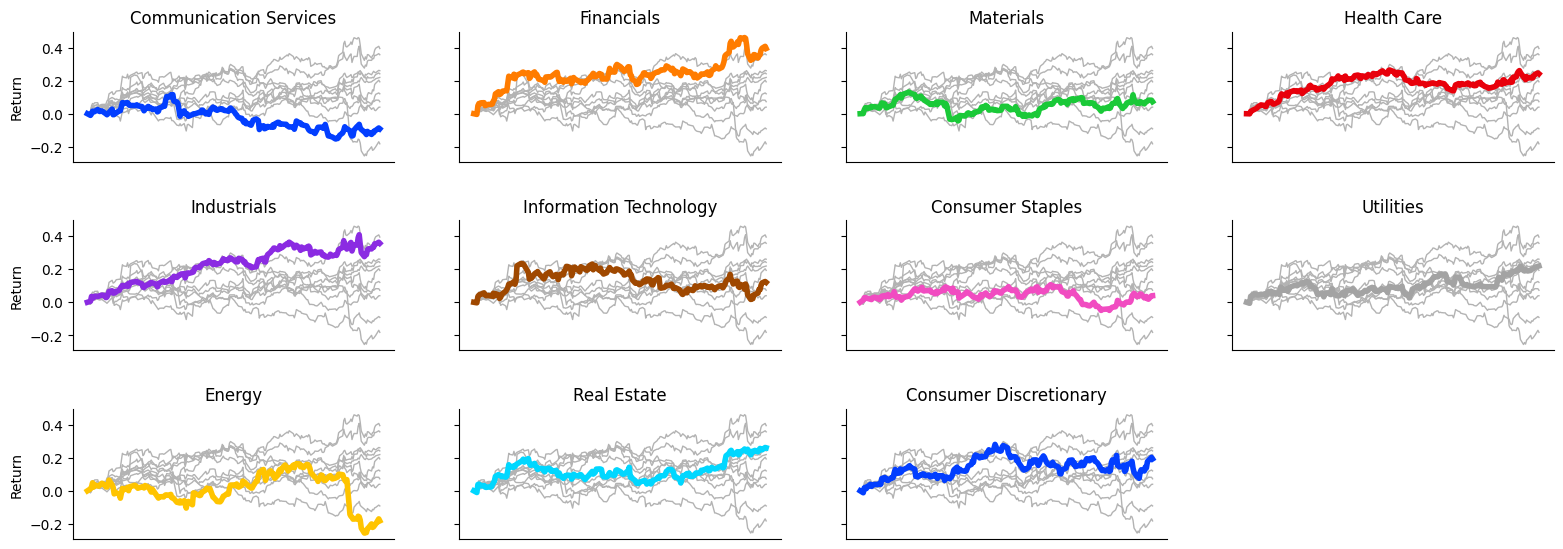

In [9]:
fig2 = sns.relplot(data=totals_melted,
        x='Date',y='Return',kind='line',hue='Sector',palette='bright',linewidth=4,col='Sector',
        zorder=5,col_wrap=4,height=2,aspect=2,legend=False)
titles = list(totals_melted['Sector'].unique())
for i, (sector,subplot) in enumerate(fig2.axes_dict.items()):
    sns.lineplot(data=totals_melted, x='Date', y='Return', units='Sector',
                estimator=None,color='.7',linewidth=1,ax=subplot)
    subplot.set_title(titles[i])
for ax in fig2.axes.flat:
    ax.get_xaxis().set_visible(False)
fig2.set_axis_labels('Date','Return')